<a href="https://colab.research.google.com/github/peggyscshu/CCP-lifetime/blob/main/One_step_CCP_Lifetime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CCP LifeTime Analysis
## Convert Imaris Tracking Result to Lifetime
1. Define variables and Install dependencies

In [ ]:
import os
import pandas as pd
import re
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import warnings
from google.colab import drive
import scipy.integrate as integrate
import scipy.optimize

## Combine A+B
1. put all imaris result in single file
2. Interval time are automaticlly generated with file name

## 2. Load Imaris tracking result and correct the track number according to the probability density function
2.1 DATA IO
✅ Add the path for Imaris measurements and output ✅ Add the Time interval here

In [ ]:
#Get the path for loading & saving data
drive.mount('/content/drive')
Raw_path_fast = ("/content/drive/MyDrive/CCP shared/Fast")
Interval_fast = 0.602
Raw_path_slow = ("/content/drive/MyDrive/CCP shared/Slow")
Interval_slow = 2.214

Files = {"Fast":os.listdir(Raw_path_fast),"Slow": os.listdir(Raw_path_slow)}
Files

Mounted at /content/drive


{'Fast': ['WT1-2_interval_0p602.xls', 'WT3-1_interval_0p602.xls'],
 'Slow': ['FweWT04-1_interval_2p214.xls', 'FweWT04-2_interval_2p214.xls']}

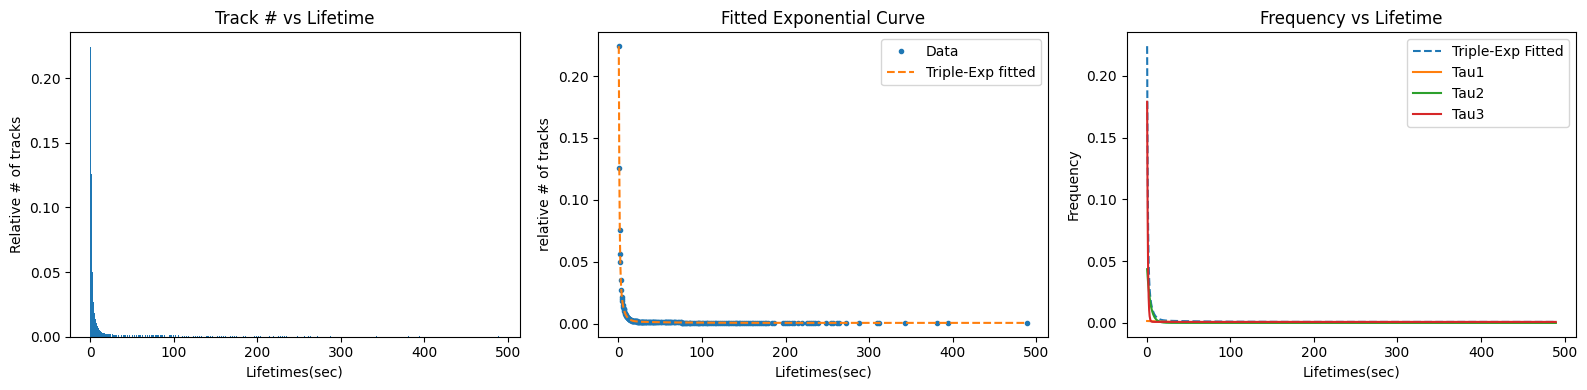

,Lifetime,Name,Population from F(t),Population from S(t),Histogram merged population,Normalized track population
0,0.602,WT1-2_interval_0p602.xlsWT3-1_interval_0p602.xls,4.500608,0.152078,4.652686,0.224102
1,1.204,WT1-2_interval_0p602.xlsWT3-1_interval_0p602.xls,2.473501,0.135100,2.608601,0.125646
2,1.806,WT1-2_interval_0p602.xlsWT3-1_interval_0p602.xls,1.453757,0.120434,1.574191,0.075823
3,2.214,FweWT04-1_interval_2p214.xlsFweWT04-2_interval...,1.061034,0.111644,1.172677,0.056483
4,2.408,WT1-2_interval_0p602.xlsWT3-1_interval_0p602.xls,0.925941,0.107759,1.033700,0.049789
...,...,...,...,...,...,...
186,312.174,FweWT04-2_interval_2p214.xls,0.015142,0.001428,0.016570,0.000798
187,343.170,FweWT04-2_interval_2p214.xls,0.015142,0.001407,0.016549,0.000797
188,380.808,FweWT04-1_interval_2p214.xls,0.015142,0.001395,0.016536,0.000796
189,394.092,FweWT04-2_interval_2p214.xls,0.015142,0.001392,0.016534,0.000796


In [ ]:
#Define the decay funcitons
def monoExp(x, a1, t1, b1):
    return a1 * np.exp(-t1 * x) + b1

def duExp(x, a1d, t1d, a2d, t2d, b2):
    return a1d * np.exp(-t1d *x) + a2d * np.exp(-t2d * x) + b2

def tpExp(x, a1t, t1t, a2t, t2t, a3t, t3t, b3):
  return a1t * np.exp(-t1t *x) + a2t * np.exp(-t2t * x) + a3t * np.exp(-t3t * x) + b3
#===== Main code star there ====
Fitting_result = pd.DataFrame(columns=["Tau1", "Tau2", "Amplitude1", "Amplitude2", "rSquared", "b2", "Integral"])
for key, value in Files.items():
  if key == "Fast":
    Raw_path = Raw_path_fast
    Interval = Interval_fast
  elif key == "Slow":
    Raw_path = Raw_path_slow
    Interval = Interval_slow
  Group_DF = pd.DataFrame()
  for i in value:
    Table_Raw = pd.read_excel(os.path.join(Raw_path,i), sheet_name=["Time Index", "Track Duration", "Track Number of Spots"], header = 1)
    # New architecture
    Temp_DF = Table_Raw["Track Duration"]
    Temp_DF["Track number of Spots"] = Table_Raw["Track Number of Spots"]["Track Number of Spots"]
    # Filter the tracks crossing over head and end
    Time_min = Table_Raw["Time Index"]["Time Index"].min()
    Time_max = Table_Raw["Time Index"]["Time Index"].max()
    Movie_length = Time_max - Time_min + 1
    Outlier_ID = (Table_Raw["Time Index"]["Time Index"] <= Time_min) |(Table_Raw["Time Index"]["Time Index"] >= Time_max)
    Outlier_ID = set(Table_Raw["Time Index"]["TrackID"][Outlier_ID])
    Final = Temp_DF[~Temp_DF["ID"].isin(Outlier_ID)]
    # Collect the final data
    Track_Summary = Final.copy()
    Track_Summary["Measured Track No"] = 1
    Track_Summary = Track_Summary.groupby("Track Duration").sum().reset_index()
    Track_Summary = Track_Summary.drop(columns = ["ID", "Unit", "Category"])
    Track_Summary["cf"] = Movie_length/(Movie_length -1 -Track_Summary["Track Duration"])
    Track_Summary["Corrected Track No"] = Track_Summary["Measured Track No"]*Track_Summary["cf"]
    # Fetch time interval from variable "Interval"
    Track_Summary["Time_interval"] = Interval
    Track_Summary["Lifetime"] = Track_Summary["Track Duration"]*Interval
    Track_Summary["Normalized spots population"] = Track_Summary["Track number of Spots"].apply(lambda x: x/Track_Summary["Track number of Spots"].sum())
    Track_Summary["Normalized track population"] = Track_Summary["Corrected Track No"].apply(lambda x: x/ Track_Summary["Corrected Track No"].sum())
    Track_Summary["Name"] = i
    # Save result to Group_DF
    Group_DF = pd.concat([Group_DF, Track_Summary])
  Group_DF.to_excel(f"/content/drive/MyDrive/CCP shared/Group_DF_{Interval}.xlsx")
  # Group by "Track duration"
  Merged_Track = Group_DF.groupby("Track Duration").sum().reset_index()
  Merged_Track["Lifetime"] = Merged_Track["Track Duration"]*Interval
  Merged_Track["Normalized track population"] = Merged_Track["Corrected Track No"].apply(lambda x: x/Merged_Track["Corrected Track No"].sum())
  Merged_Track = Merged_Track.drop(columns=["Track number of Spots", "Measured Track No", "cf", "Normalized spots population"])
  Merged_Track.to_excel(f"/content/drive/MyDrive/CCP shared/Merged_Track_{Interval}.xlsx", index=False)
  ## Fitting: dualexponential fit
  xs = Merged_Track["Lifetime"]
  ys = Merged_Track["Normalized track population"]
  p0 = (Merged_Track["Normalized track population"].max(), .1, Merged_Track["Normalized track population"].max(), .1,0) # start with values near those we expect
  poptd, cvd = scipy.optimize.curve_fit(duExp, xs, ys, p0, bounds=((-np.inf, 0, -np.inf, 0, -np.inf),(np.inf, np.inf, np.inf, np.inf, np.inf)))## restrict Tau1 and Tau2 between 0 and Inf. to avoid overflow !!
  a1d, t1d, a2d, t2d, b2 = poptd
  tau1dSec = (1 / t1d)
  tau2dSec = (1 / t2d)
  # determine quality of the dualexponential fit
  squaredDiffs = np.square(ys - duExp(xs, a1d, t1d, a2d, t2d, b2))
  squaredDiffsFromMean = np.square(ys - np.mean(ys))
  rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
  # Intergal 30 to 50
  f1 = lambda x : a1d * np.exp(-t1d *x) + a2d * np.exp(-t2d * x) + b2
  area = integrate.quad(f1, 30, 50)
  # Save the the fitting result
  Fitting_result.loc[0]=[tau1dSec, tau2dSec, a1d, a2d, rSquared, b2, area[0]]
  with pd.ExcelWriter(f"/content/drive/MyDrive/CCP shared/Fitting_integral_{Interval}.xlsx") as writer:
    Merged_Track.to_excel(writer, sheet_name="Merged_Track")
    Fitting_result.to_excel(writer, sheet_name="Fitting_result")


# Reload data and Calculate alph
Path_Merged_Track_Fast = (f"/content/drive/MyDrive/CCP shared/Fitting_integral_{Interval_fast}.xlsx")
Path_Merged_Track_Slow = (f"/content/drive/MyDrive/CCP shared/Fitting_integral_{Interval_slow}.xlsx")
Merged_Track_Fast = pd.read_excel(Path_Merged_Track_Fast, sheet_name = ["Merged_Track","Fitting_result"], header = 0,index_col = 0)
Merged_Track_Slow = pd.read_excel(Path_Merged_Track_Slow, sheet_name = ["Merged_Track","Fitting_result"], header = 0, index_col = 0)
Table_Raw_Fast = Merged_Track_Fast["Merged_Track"].copy()
Table_Raw_Slow = Merged_Track_Slow["Merged_Track"].copy()
alph = Merged_Track_Slow["Fitting_result"].iat[0,6]/Merged_Track_Fast["Fitting_result"].iat[0,6]
# Normalize F(t) with alpha
Table_Raw_Fast["Normalized track population"] = Merged_Track_Fast["Merged_Track"]["Normalized track population"] * alph
## Fitting: dualexponential fit - To renew function of normalized Table_Raw_Fast
xs = Table_Raw_Fast["Lifetime"]
ys = Table_Raw_Fast["Normalized track population"]
p0 = (Table_Raw_Fast["Normalized track population"].max(), .1, Table_Raw_Fast["Normalized track population"].max(), .1,0) # start with values near those we expect
poptd, cvd = scipy.optimize.curve_fit(duExp, xs, ys, p0, bounds=((-np.inf, 0, -np.inf, 0, -np.inf),(np.inf, np.inf, np.inf, np.inf, np.inf)))## restrict Tau1 and Tau2 between 0 and Inf. to avoid overflow !!
a1d, t1d, a2d, t2d, b2 = poptd
tau1dSec = (1 / t1d)
tau2dSec = (1 / t2d)
# determine quality of the dualexponential fit
squaredDiffs = np.square(ys - duExp(xs, a1d, t1d, a2d, t2d, b2))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
Merged_Track_Fast["Fitting_result"].loc[0] = [tau1dSec, tau2dSec, a1d, a2d, rSquared, b2, 0.0]
# Create the datapoints
Normalized_df = pd.concat([Table_Raw_Fast, Table_Raw_Slow])
Normalized_df = Normalized_df.drop(columns = ["Track Duration", "Corrected Track No", "Normalized track population","Time_interval"])
Normalized_df.sort_values(by = ["Lifetime"], inplace = True, ignore_index = True)
# Get Normalized F(t)
Normalized_df["Population from F(t)"] = duExp(Normalized_df["Lifetime"], a1d, t1d, a2d, t2d, b2)
# Get Normalized S(t)
Fitting_slow = Merged_Track_Slow["Fitting_result"].loc[0]
Normalized_df["Population from S(t)"] = duExp(Normalized_df["Lifetime"], Fitting_slow.iloc[2], 1/Fitting_slow.iloc[0], Fitting_slow.iloc[3], 1/Fitting_slow.iloc[1], Fitting_slow.iloc[5])
Normalized_df['Histogram merged population'] = Normalized_df["Population from F(t)"] + Normalized_df["Population from S(t)"]
Normalized_df["Normalized track population"] = Normalized_df["Histogram merged population"] / Normalized_df["Histogram merged population"].sum()
#Normalized_df.to_excel(f"/content/drive/MyDrive/CCP shared/Normalized_df_{Interval_fast}to{Interval_slow}.xlsx")
#Normalized_df
# Plot relative # of tracks vs lifetime
Triple_Exp_R = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
xs = Normalized_df["Lifetime"]
ys = Normalized_df["Normalized track population"]
plt.bar(xs,ys)
plt.xlabel("Lifetimes(sec)")
plt.ylabel("Relative # of tracks")
plt.title("Track # vs Lifetime")
## Fitting: Triple exponential fit
xs = Normalized_df["Lifetime"]
ys = Normalized_df["Normalized track population"]
p0 = (Normalized_df['Normalized track population'].max(), 0.02, Normalized_df['Normalized track population'].max(), 0.25,Normalized_df['Normalized track population'].max(), 1.25,0) # start with values near those we expect
poptt, cvt = scipy.optimize.curve_fit(tpExp, xs, ys , p0, bounds = ((-np.inf, 0, -np.inf, 0, -np.inf, 0, -np.inf),(np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)))#optimized parameters and covariants
a1t, t1t, a2t, t2t, a3t, t3t, b3 = poptt
tau1tSec = (1 / t1t)
tau2tSec = (1 / t2t)
tau3tSec = (1 / t3t)
# Determine quality of the triple exponential fit
squaredDiffs = np.square(ys - tpExp(xs, a1t, t1t, a2t, t2t, a3t, t3t, b3))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
tpxExp_para = pd.DataFrame(columns=["Tau1", "Tau2", "Tau3", "Amplitude1", "Amplitude2", "Amplitude3", "b3", "rSquared"])
tpxExp_para.loc[0] = [tau1tSec, tau2tSec, tau3tSec, a1t, a2t, a3t, b3,rSquared]
# Save the the fitting result
with pd.ExcelWriter(f"/content/drive/MyDrive/CCP shared/Normalized_df_{Interval_fast}to{Interval_slow}.xlsx") as writer:
  Normalized_df.to_excel(writer, sheet_name="Normalized_df")
  tpxExp_para.to_excel(writer, sheet_name="Fitting_result")
# Plot the result of Triple exponential fitting
plt.subplot(1,3,2)# Triple-ExP Fitting cureve
xs = Normalized_df["Lifetime"]
ys = Normalized_df["Normalized track population"]
plt.plot(xs, ys, '.', label="Data")
plt.plot(xs, tpExp(xs, a1t, t1t, a2t, t2t, a3t, t3t, b3), '--', label="Triple-Exp fitted")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("relative # of tracks")
plt.title("Fitted Exponential Curve")
plt.legend()

# Plot frequency vs lifetime of the triple exponential model
plt.subplot(1,3,3)
plt.plot(xs, tpExp(xs, a1t, t1t, a2t, t2t, a3t, t3t, b3), '--', label="Triple-Exp Fitted")
plt.plot(xs, monoExp(xs, a1t, t1t,0), '-', label="Tau1")
plt.plot(xs, monoExp(xs, a2t, t2t,0), '-', label="Tau2")
plt.plot(xs, monoExp(xs, a3t, t3t,b3), '-', label="Tau3")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("Frequency")
plt.title("Frequency vs Lifetime")
plt.legend()
plt.tight_layout()
plt.show()

Normalized_df























## 4. Relative contributions of each component

3.516082289309547
15.036978518585157


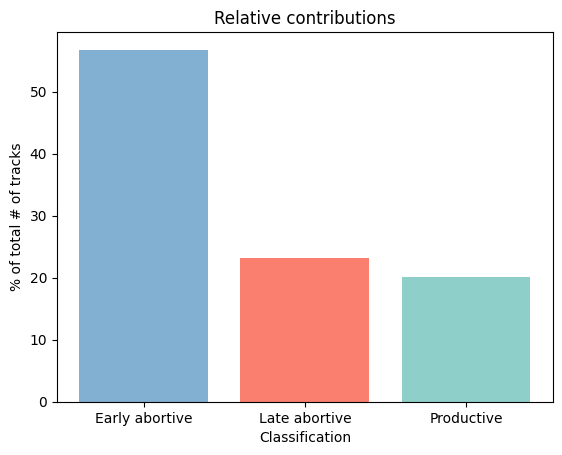

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get the parameters for each classification
tpxExp_para.insert(6,"b1",0)
tpxExp_para.insert(7,"b2",0)
tpxExp_para = tpxExp_para.drop(columns=["rSquared"])
Tau_df = pd.DataFrame(tpxExp_para.values.reshape(-1,3))
Tau_df = pd.concat([Tau_df.iloc[0:2,:],(Tau_df.iloc[0:1].apply(lambda x: 1/x)),Tau_df.iloc[2:]], axis=0, ignore_index= True)
Tau_df = Tau_df.sort_values(by=0, axis=1, ascending = False)
Tau_df.rename(columns={0:"Productive", 1:"Late abortive", 2:"Early abortive"}, inplace=True)
Tau_df.insert(0, "Parameter", ["Tau", "a", "t", "b"])

# Calculate the critical point (cross point)
xc1 = (np.log(Tau_df.iat[1,2])-np.log(Tau_df.iat[1,3])-np.log(Tau_df.iat[3,3]))/(Tau_df.iat[2,3]+Tau_df.iat[2,2])
print(xc1)
xc2 = (np.log(Tau_df.iat[1,1])-np.log(Tau_df.iat[1,2]))/(Tau_df.iat[2,1]-Tau_df.iat[2,2])
print(xc2)
Tau_df

# Classify
Normalized_df["Classification"] = Normalized_df["Lifetime"].apply(lambda x: "Early abortive" if x <= xc1 else("Late abortive" if x<= xc2 else "Productive"))

# Draw the relative contributions
Table_Classify = Normalized_df.copy().groupby("Classification").sum().reset_index()
Table_Classify["Relative contributions"] = Table_Classify["Histogram merged population"].apply(lambda x: x*100/Table_Classify["Histogram merged population"].sum())
Table_Classify = Table_Classify.drop(columns=["Lifetime", "Name", "Population from F(t)", "Population from S(t)"])
# Plot
x = Table_Classify["Classification"]
y = Table_Classify["Relative contributions"]
Relative_contributions = plt.figure()
plt.bar(x,y, color = ["#82B0D2", "#FA7F6F", "#8ECFC9"])
plt.xlabel("Classification")
plt.ylabel("% of total # of tracks")
plt.title("Relative contributions")
plt.show()
plt.savefig(f"/content/drive/MyDrive/CCP shared/Relative_contributions_{Interval_fast}to{Interval_slow}.png", transparent = True, dpi = 300)


# Save the final Normalized_df data
with pd.ExcelWriter(f"/content/drive/MyDrive/CCP shared/Normalized_df_{Interval_fast}to{Interval_slow}.xlsx") as writer:
  Normalized_df.to_excel(writer, sheet_name="Normalized_df")
  Tau_df.to_excel(writer, sheet_name="Fitting_result")





## 5. Lifetime Median, Q1 and Q3

In [ ]:
# Simplify the table and set Variables
contri_early = Table_Classify.at[0,"Relative contributions"]
contri_late = Table_Classify.at[1,"Relative contributions"]
conttri_productive = Table_Classify.at[2,"Relative contributions"]
Table_boxplot = Normalized_df.copy()
Table_boxplot = Table_boxplot.drop(columns=["Name", "Population from F(t)", "Population from S(t)"])
# Get MaxInd of each population
Table_count = Table_boxplot.groupby("Classification").count().reset_index()
Table_count.rename(columns = {"Histogram merged population":"Track count"}, inplace = True)
Table_count = Table_count.drop(columns=['Lifetime'])
Table_count
# Split the data into three categories(Check this part!!!)
df_3_cat = Table_boxplot.copy()
df_early = df_3_cat[df_3_cat["Classification"]=="Early abortive"]
df_late = df_3_cat[df_3_cat["Classification"]=="Late abortive"]
df_productive = df_3_cat[df_3_cat["Classification"]=="Productive"]
# Acumulate sum of the Normalized track polulation
df_early.loc[:,"Normalized track population"] = df_early["Normalized track population"] * 100/contri_early
df_early.insert(len(df_early.columns), "AccSum_Normalized track population", df_early["Normalized track population"].cumsum())
df_early = df_early.drop(columns=["Normalized track population", "Histogram merged population"])

df_late.loc[:,"Normalized track population"] = df_late["Normalized track population"] * 100/contri_late
df_late.insert(len(df_late.columns), "AccSum_Normalized track population",df_late["Normalized track population"].cumsum())
df_late = df_late.drop(columns=["Normalized track population", "Histogram merged population"])

df_productive.loc[:,"Normalized track population"] = df_productive["Normalized track population"] * 100/conttri_productive
df_productive.insert(len(df_productive.columns), "AccSum_Normalized track population",df_productive["Normalized track population"].cumsum())
df_productive = df_productive.drop(columns=["Normalized track population", "Histogram merged population"])




In [ ]:
# Q1, Median, Q3 of early abortive
AccSum = df_early["AccSum_Normalized track population"].to_list()
bins = [0.25,0.5,0.75,0.9999]
inds = np.digitize(AccSum, bins)
LifeT = df_early["Lifetime"].to_list()
zipped = zip(LifeT, inds)
zipped = sorted(zipped, key=lambda x: (x[0], x[1]))
Q_earlyArray = []
for i,(LT, ind) in enumerate(zipped):
  if ind == 1 and len(Q_earlyArray) ==0:
    Q_earlyArray.append(LT)
  elif inds[i-1] != ind and len(Q_earlyArray) !=0:
    Q_earlyArray.append(LT)
Q_earlyArray.insert(0,zipped[0][0])
Q_earlyArray


[0.602, 0.602, 1.204, 1.806, 3.01]

In [ ]:
# Q1, Median, Q3 of late abortive
AccSum = df_late["AccSum_Normalized track population"].to_list()
bins = [0.25,0.5,0.75,0.9999]
inds = np.digitize(AccSum, bins)
LifeT = df_late["Lifetime"].to_list()
zipped = zip(LifeT, inds)
zipped = sorted(zipped, key=lambda x: (x[0], x[1]))
Q_lateArray = []
for i,(LT, ind) in enumerate(zipped):
  if ind == 1 and len(Q_lateArray) ==0:
    Q_lateArray.append(LT)
  elif inds[i-1] != ind and len(Q_lateArray) !=0:
    Q_lateArray.append(LT)

Q_lateArray.insert(0,zipped[0][0])
Q_lateArray


[3.612, 4.428, 6.02, 8.856, 14.448]

In [ ]:
# Q1, Median, Q3 of productive
AccSum = df_productive["AccSum_Normalized track population"].to_list()
bins = [0.25,0.5,0.75,0.9999]
inds = np.digitize(AccSum, bins)
LifeT = df_productive["Lifetime"].to_list()
zipped = zip(LifeT, inds)
zipped = sorted(zipped, key=lambda x: (x[0], x[1]))
Q_productiveArray = []
for i,(LT, ind) in enumerate(zipped):
  if ind == 1 and len(Q_productiveArray) ==0:
    Q_productiveArray.append(LT)
  elif inds[i-1] != ind and len(Q_productiveArray) !=0:
    Q_productiveArray.append(LT)

Q_productiveArray.insert(0,zipped[0][0])
Q_productiveArray


[15.05, 25.886, 53.136, 115.128, 489.294]

## 6. Calculate mean


In [ ]:
Table_boxplot
Table_boxplot["Normalized track population * Lifetime"] = Table_boxplot["Normalized track population"] * Table_boxplot["Lifetime"]
Table_boxplot_Classify = Table_boxplot.groupby("Classification").sum()
Table_boxplot_Classify["Lifetime mean"] = Table_boxplot_Classify["Normalized track population * Lifetime"]/Table_boxplot_Classify["Normalized track population"]
Table_boxplot_Classify = Table_boxplot_Classify.drop(columns = ['Lifetime',"Histogram merged population", "Normalized track population", "Normalized track population * Lifetime"])
Table_boxplot_Classify


,Lifetime mean
Classification,
Early abortive,1.365926
Late abortive,6.980154
Productive,83.310652


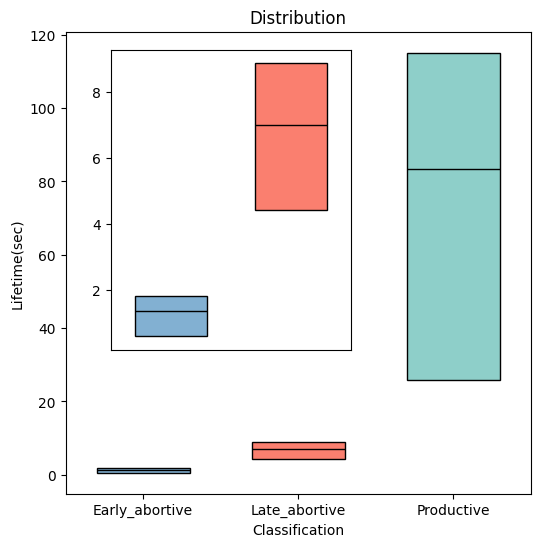

{'whiskers': [<matplotlib.lines.Line2D object at 0x7c457bc02510>, <matplotlib.lines.Line2D object at 0x7c4582e569d0>, <matplotlib.lines.Line2D object at 0x7c4580d19290>, <matplotlib.lines.Line2D object at 0x7c457bb6ed90>], 'caps': [], 'boxes': [<matplotlib.patches.PathPatch object at 0x7c457ba876d0>, <matplotlib.patches.PathPatch object at 0x7c4588267010>], 'medians': [<matplotlib.lines.Line2D object at 0x7c457ba85210>, <matplotlib.lines.Line2D object at 0x7c457b918ad0>], 'fliers': [], 'means': []}


In [ ]:
# Plot
data = [Q_earlyArray, Q_lateArray, Q_productiveArray]
Color = ['#82B0D2', '#FA7F6F', '#8ECFC9']
fig = plt.figure(figsize =(6, 6))
bp = plt.boxplot(data, tick_labels = ["Early_abortive", "Late_abortive", "Productive"], usermedians=[Table_boxplot_Classify.iloc[0,0], Table_boxplot_Classify.iloc[1,0], Table_boxplot_Classify.iloc[2,0]], showfliers=False, showmeans=False, showcaps = False, whis =0, widths = 0.6, positions = (1,2,3), patch_artist = True, medianprops = {'color': "black", 'linewidth': 1})
for box, cr in zip(bp["boxes"], Color):
    box.set_facecolor(cr)
plt.xlabel("Classification")
plt.title("Distribution")
plt.ylabel("Lifetime(sec)")
# 左上角子圖
ax = fig.add_axes([0.2, 0.35, 0.4 ,0.5])
Axex = plt.boxplot(data[0:2], usermedians=[Table_boxplot_Classify.iloc[0,0], Table_boxplot_Classify.iloc[1,0]], showfliers=False, showmeans=False, showcaps = False, whis =0, widths = 0.6, tick_labels=["",""], patch_artist = True, medianprops = {'color': "black", 'linewidth': 1})
for box, cr in zip(Axex["boxes"], Color):
    box.set_facecolor(cr)
ax.tick_params(bottom = False)

plt.show()